In [ ]:
# this notebook is used for evaluation performance of logistic-calibrated raw protein probability and MLP with raw protein probability and mRNA as input 

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import pandas as pd
import numpy as np
from graphgym.custom_graphgym.loader.protein import ProteinDataset
import os

In [2]:
# %connect_info
# %qtconsole

Import data from csv fies

In [2]:
os.chdir('/Users/cgu3/Documents/Grape-Pi')
# dataset = ProteinDataset("data/yeast-ORBI", numeric_columns=['protein_probability'], label_column=None, rebuild=True)
# dataset = ProteinDataset("data/yeast-ORBI", numeric_columns=['protein_probability', 'mRNA(M)'], label_column=None, rebuild=True)
dataset = ProteinDataset("data/yeast-LCQ", numeric_columns=['protein probability'], label_column=None, rebuild=True)
# dataset = ProteinDataset("data/yeast-LCQ", numeric_columns=['protein probability', 'mRNA(M)'], label_column=None, rebuild=True)

In [3]:
dataset.x

Global seed set to 42


42

In [17]:
dataset.y[dataset.train_mask].long().bincount()
dataset.y[dataset.val_mask].long().bincount()
dataset.y[dataset.test_mask].long().bincount()

In [18]:
# print(f'Number of nodes: {dataset.num_nodes}')
print(f'Number of node features: {dataset.num_node_features}')
# print(f'Number of edges: {dataset.num_edges}')
print(f'Number of edge features: {dataset.num_edge_features}')
# print(f'Average node degree: {dataset.num_edges / dataset.num_nodes:.2f}')
print(f'Number of training nodes: {dataset.train_mask.sum()}')
# print(f'Training node label rate: {int(dataset.train_mask.sum()) / dataset.num_nodes:.2f}')
# print(f'Validation node label rate: {int(dataset.val_mask.sum()) / dataset.num_nodes:.2f}')
# print(f'Test node label rate: {int(dataset.test_mask.sum()) / dataset.num_nodes:.2f}')
# print(f'Has isolated nodes: {dataset.has_isolated_nodes()}')
# print(f'Has self-loops: {dataset.has_self_loops()}')
# print(f'Is undirected: {dataset.is_undirected()}')

In [10]:
from torch.utils.data import DataLoader
import torch
train_dataset = torch.utils.data.TensorDataset(dataset.x[dataset.train_mask], dataset.y[dataset.train_mask])
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
val_dataset = torch.utils.data.TensorDataset(dataset.x[dataset.val_mask], dataset.y[dataset.val_mask])
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)
test_dataset = torch.utils.data.TensorDataset(dataset.x[dataset.test_mask], dataset.y[dataset.test_mask])
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

Rebuilding...


Positive vs negative in train dataset: tensor([1427, 1139])
Positive vs negative in val dataset: tensor([170, 151])
Positive vs negative in test dataset: tensor([178, 143])
Number of node features: 1
Number of edge features: 0
Number of training nodes: 2566


Done!


In [36]:
import torchmetrics
import os
from torch import optim, nn, utils, Tensor
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
import pytorch_lightning as pl
pl.seed_everything(42)
from torchmetrics.classification import BinaryAUROC, BinaryAccuracy, BinaryF1Score


# define the LightningModule
class MLP(pl.LightningModule):
    def __init__(self, num_features, hidden_channels, num_classes, criterion):
        super().__init__()
        self.lin1 = nn.Linear(num_features, hidden_channels)
        self.lin2 = nn.Linear(hidden_channels, hidden_channels)
        self.lin3 = nn.Linear(hidden_channels, num_classes)
        self.criterion = criterion
        
        self.val_collection = torchmetrics.MetricCollection([BinaryAccuracy(), BinaryAUROC(), BinaryF1Score()])
        self.test_collection = torchmetrics.MetricCollection([BinaryAccuracy(), BinaryAUROC(), BinaryF1Score()])
        
    def forward(self, x):
        x = self.lin1(x)
        x = x.relu()
        x = self.lin2(x)
        x = x.relu()
        x = self.lin3(x)
        return x

    def get_auc(self, out, target):
        return self.auroc(torch.sigmoid(out)[:, 1], target)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)  # Perform a single forward pass.

        loss = self.criterion(logits.squeeze(-1), y)  # Compute the loss solely based on the training nodes.
        values = {"loss": loss}
        self.log_dict(values, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)  # Perform a single forward pass.
        loss = self.criterion(logits.squeeze(-1), y)  # Compute the loss solely based on the training nodes.
        
        self.val_collection.update(logits.squeeze(-1), y)
        self.log_dict(self.val_collection, prog_bar=True, on_step=False, on_epoch=True)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        
        loss = self.criterion(logits.squeeze(-1), y)
        self.test_collection.update(logits.squeeze(-1), y)
        self.log_dict(self.test_collection, prog_bar=True, on_step=False, on_epoch=True)
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        return optimizer



Rebuilding...


Positive vs negative in train dataset: tensor([1429, 1137])
Positive vs negative in val dataset: tensor([173, 148])
Positive vs negative in test dataset: tensor([173, 148])
Number of node features: 1
Number of edge features: 0
Number of training nodes: 2566


Done!


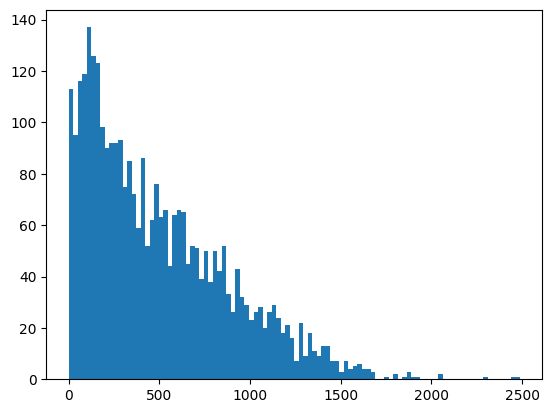

In [37]:
# init the autoencoder
MLP_model = MLP(dataset.num_node_features, 10, 1, criterion = torch.nn.BCEWithLogitsLoss())

In [27]:
trainer = pl.Trainer(max_epochs=20, enable_progress_bar = True)
trainer.fit(model=MLP_model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       BinaryAUROC          0.8453815579414368
     BinaryAccuracy         0.8099688291549683
      BinaryF1Score         0.7749077677726746
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'BinaryAccuracy': 0.8099688291549683,
  'BinaryAUROC': 0.8453815579414368,
  'BinaryF1Score': 0.7749077677726746}]

In [ ]:
trainer.test(model=MLP_model, dataloaders=test_dataloader)

Rebuilding...


Positive vs negative in train dataset: tensor([1410, 1156])
Positive vs negative in val dataset: tensor([176, 145])
Positive vs negative in test dataset: tensor([189, 132])
Number of node features: 2
Number of edge features: 0
Number of training nodes: 2566


Done!


In [30]:
%reload_ext tensorboard
%tensorboard --logdir=lightning_logs/

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name            | Type              | Params
------------------------------------------------------
0 | lin1            | Linear            | 30    
1 | lin2            | Linear            | 110   
2 | lin3            | Linear            | 11    
3 | criterion       | BCEWithLogitsLoss | 0     
4 | val_collection  | MetricCollection  | 0     
5 | test_collection | MetricCollection  | 0     
------------------------------------------------------
151       Trainable params
0         Non-trainable params
151       Total params
0.001     Total estimated model params size (MB)
/Users/cgu3/opt/anaconda3/envs/Grape-Pi/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (41) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       BinaryAUROC            0.877685546875
     BinaryAccuracy         0.8099688291549683
      BinaryF1Score         0.7550200819969177
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'BinaryAccuracy': 0.8099688291549683,
  'BinaryAUROC': 0.877685546875,
  'BinaryF1Score': 0.7550200819969177}]

In [ ]:
from torch_geometric.nn import GCNConv
import torch_geometric.nn as nn

class GCN(torch.nn.Module):
    def __init__(self, num_node_features, hidden_channels, num_classes):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        # self.batch_norm1 = nn.BatchNorm(hidden_channels)
        self.conv2 = GCNConv(hidden_channels, num_classes)
        # self.batch_norm2 = nn.BatchNorm(hidden_channels)


    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        # use batchnorm instead of dropout
        x = F.dropout(x, p=0.5, training=self.training)
        # x = self.batch_norm1(x)
        x = self.conv2(x, edge_index)
        return x

model = GCN(num_node_features=dataset.num_node_features, hidden_channels=16, num_classes=2)
print(model)

In [31]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

# uncomment for first time run
# !pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
# !pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
# !pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# Helper function for visualization.
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=30, alpha=0.5, c=color, cmap="Set2")
    plt.show()

Rebuilding...


Positive vs negative in train dataset: tensor([1431, 1136])
Positive vs negative in val dataset: tensor([178, 143])
Positive vs negative in test dataset: tensor([167, 154])
Number of node features: 1
Number of edge features: 0
Number of training nodes: 2567


Done!


In [32]:
model = GCN(num_node_features=dataset.num_node_features, hidden_channels=16, num_classes=2)
model.eval()

out = model(dataset.x, dataset.edge_index)
visualize(out, color=dataset.y)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name            | Type              | Params
------------------------------------------------------
0 | lin1            | Linear            | 20    
1 | lin2            | Linear            | 110   
2 | lin3            | Linear            | 11    
3 | criterion       | BCEWithLogitsLoss | 0     
4 | val_collection  | MetricCollection  | 0     
5 | test_collection | MetricCollection  | 0     
------------------------------------------------------
141       Trainable params
0         Non-trainable params
141       Total params
0.001     Total estimated model params size (MB)
/Users/cgu3/opt/anaconda3/envs/Grape-Pi/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (41) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       BinaryAUROC          0.6336417198181152
     BinaryAccuracy         0.6230529546737671
      BinaryF1Score         0.4265402853488922
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'BinaryAccuracy': 0.6230529546737671,
  'BinaryAUROC': 0.6336417198181152,
  'BinaryF1Score': 0.4265402853488922}]

In [ ]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = GCN(num_node_features=dataset.num_node_features, hidden_channels=10, num_classes=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(dataset.x, dataset.edge_index)  # Perform a single forward pass.
      train_loss = criterion(out[dataset.train_mask], dataset.y[dataset.train_mask])  # Compute the loss solely based on the training nodes.
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      train_correct = pred[dataset.train_mask] == dataset.y[dataset.train_mask]  # Check against ground-truth labels.
      train_acc = int(train_correct.sum()) / int(dataset.train_mask.sum())
      train_loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return float(train_loss.detach()), train_acc


def val():
      model.eval()
      out = model(dataset.x, dataset.edge_index)
      val_loss = criterion(out[dataset.val_mask], dataset.y[dataset.val_mask])
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      val_correct = pred[dataset.val_mask] == dataset.y[dataset.val_mask] # Check against ground-truth labels.
      val_acc = int(val_correct.sum()) / int(dataset.val_mask.sum())  # Derive ratio of correct predictions.
      return float(val_loss.detach()), val_acc

def test():
      model.eval()
      out = model(dataset.x, dataset.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[dataset.test_mask] == dataset.y[dataset.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(dataset.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc

train_loss_history = []
train_acc_history = []
val_acc_history = []
val_loss_history = []
for epoch in range(1, 101):
    train_loss, train_acc = train()
    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)
    val_loss, val_acc = val()
    val_loss_history.append(val_loss)
    val_acc_history.append(val_acc)
    print(f'Epoch: {epoch:03d}, Train loss: {train_loss:.4f} Train acc: {train_acc:.4f} '
          f'Validation loss: {val_loss: .4f}, Validation acc: {val_acc:.4f}')

In [33]:
plt.plot(train_loss_history)
plt.plot(val_loss_history)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

plt.plot(train_acc_history)
plt.plot(val_acc_history)
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()


Rebuilding...


Positive vs negative in train dataset: tensor([1439, 1128])
Positive vs negative in val dataset: tensor([159, 162])
Positive vs negative in test dataset: tensor([178, 143])
Number of node features: 2
Number of edge features: 0
Number of training nodes: 2567


Done!


In [35]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name            | Type              | Params
------------------------------------------------------
0 | lin1            | Linear            | 30    
1 | lin2            | Linear            | 110   
2 | lin3            | Linear            | 11    
3 | criterion       | BCEWithLogitsLoss | 0     
4 | val_collection  | MetricCollection  | 0     
5 | test_collection | MetricCollection  | 0     
------------------------------------------------------
151       Trainable params
0         Non-trainable params
151       Total params
0.001     Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=50` reached.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       BinaryAUROC           0.81549072265625
     BinaryAccuracy          0.732087254524231
      BinaryF1Score         0.6884058117866516
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'BinaryAccuracy': 0.732087254524231,
  'BinaryAUROC': 0.81549072265625,
  'BinaryF1Score': 0.6884058117866516}]

In [ ]:
model.eval()

out = model(dataset.x, dataset.edge_index)
visualize(out, color=dataset.y)

In [ ]:
# when dataset contain two graph
# to-do create dataset class


# need good standardization to generalize to model to different spices and experiment conditions
# semi-supervise
# transfer learning


# the performance is not good
# need to include more nodes features: protein characteristics, ...
# more ideal not use calculated protein score, instead use variables used to calculate protein score directly



# GPU resource